## **Unified Differential Evolution for the Global Optimisation of Standard Benchmark Functions**

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import time
%matplotlib inline

### **SEARCH ALGORITHMS**

In [3]:
# ---- Unified Differential Evolution Implementation ----

class DifferentiaEvolution:
    
    def __init__(self, function, bounds, popsize, iterations, CR, F, stagnation = 100):
        """ Constructor method to initialise differential evolution algorithm
    
        Args:
            function (function): The objective function to be optimised
            bounds (array): Array of tuples containing upper and lower bounds of each dimension of the search space
            popsize (int): Number of cadidate solutions/ agents in the population
            iterations (int): Number of iterations 
            CR (float): Probability of crossover operation
            F (list): List of Scaling Factors for unified mutation operation
            stagnation (int, optional): Stops execution early if lowest cost remains the same for given amount of iterations, defaults to 100.
        """
        
        # Initialise problem instance, algorithm parameters, and termination criterion
        self.function = function
        self.bounds = bounds
        self.stagnation = stagnation
        self.iterations = iterations
        self.popsize = popsize
        self.CR = CR
        self.F= F
        self.dim = len(bounds)
        
        # Initialising array for population of agents
        self.population = np.zeros((self.popsize, self.dim))
        # Iterate through each dimension and randomly assign values across entire parameter space while adhering to dimension bounds
        for i in range(self.dim):
            lower_bound, upper_bound = self.bounds[i]
            self.population[:, i] = np.random.uniform(low = lower_bound, high = upper_bound, size = self.popsize)
        
        # Performance Metrics    
        self.AvgCostHistory = []
        self.LowestCostHistory = []
        self.ConvergenceSpeed = np.inf
        self.SolutionQuality = np.inf
        self.ExecutionTime = np.inf
        self.DiversityMetric = []    
        
    def run(self):
        """ Method runs the differential evolution using unified mutation operation in schema defined by scaling factors parsed during initialisation

        Returns:
            SolutionQuality (float): Best objective function value (cost)
            MinimaCoords (array): Coordinates of solution associated with best cost found given in SolutionQuality
            ConvergenceSpeed (int): Number of iterations taken for average solution cost and best solution cost to converge
            ExecutionTime (float): Time taken for DE algorithm execution
            DiversityMetric (array): Average pairwiase euclidean distance between all solutions in the population at each generation
            LowestCostHistory (array): Lowest cost/ objective function value of best solution in each generation
            AvgCostHistory (array): Average cost of solutions in each generation
        """
        
        # Track number of iterations without improvement for early stopping if lowest cost has stagnated
        stagnation_count, previous = 0, 0
        
        start_time = time.time()
        # For each generation (G) in number of iterations
        for G in range(self.iterations):
            
            # ---- Calculating Performance Metrics ----
            cost = [self.function(agent) for agent in self.population]
            min_cost_idx = np.argmin(cost)
            min_cost = cost[min_cost_idx]
            
            self.AvgCostHistory.append(np.mean(cost))
            self.LowestCostHistory.append(min_cost)
            if min_cost < self.SolutionQuality:
                self.SolutionQuality = min_cost
                self.MinimaCoords = self.population[min_cost_idx]
                
            # Checks for convergence
            if np.mean(cost) == min_cost:
                self.ConvergenceSpeed = int(G)
            
            # Calculating pairwise distances for diversity metric calculation
            pairwise_distances = np.zeros((self.popsize, self.popsize))
            for i in range(self.popsize):
                for j in range(self.popsize):
                    distance = np.linalg.norm(self.population[i] - self.population[j])
                    # We can half amount of calculations by noticing this is a symmetric matrix
                    pairwise_distances[i, j], pairwise_distances[j, i] = distance, distance
            # Calculate the total number of pairwise distances
            num_pairs = (self.popsize * (self.popsize - 1)) // 2
            self.DiversityMetric.append(np.sum(pairwise_distances) / num_pairs)

            # For each agent (target vector) x_i = 1,2,...,NP at generation G
            for idx in range(self.popsize):
                
                # ---- MUTATION ----
                
                # Gathering parameters needed to use unified mutation strategy equation
                agent = self.population[idx]

                cost = [self.function(agent) for agent in self.population]
                best_idx = np.argmin(cost)
                best = self.population[best_idx]
                
                # Ensuring random agents are all distinct selected between 1, NP and different from current idx (i)
                popidx = np.arange(len(self.population))
                popidx = np.delete(popidx, (idx, best_idx))
                randomidx = np.random.choice(popidx, size = 5, replace = False)
                r1, r2, r3, r4, r5 = self.population[randomidx]
                F1, F2, F3, F4 = self.F[0], self.F[1], self.F[2], self.F[3]

                # uDE equation by definition
                mutant = agent + F1*(best - agent) + F2*(r1 - agent) + F3*(r2 - r3) + F4*(r4 - r5)
                
                # ---- CROSSOVER ----
                
                # Binomial crossover scheme
                
                # Initialise trial vector
                trial = np.copy(agent)
                
                # Randomly selecting integer in range [1,D]
                i = np.random.randint(0, self.dim)
                
                # For each dimension/ element of vectors
                for j in range(self.dim):
                    
                    # If randj <= CR we crossover and insert mutant gene in trial vector for that dimension
                    # i == j condition ensures that at least one component in trial vector comes from the mutant vector
                    if np.random.uniform() <= self.CR or i == j:
                        trial[j] = mutant[j]
                    # Else we draw gene for current dimension from the original agent genome
                    else:
                        trial[j] = agent[j]
                        
                # ---- SELECTION ----
                
                # Checking trial solution against boundary constraints in control parameter space
                for j in range(self.dim):
                    lower_bound, upper_bound = self.bounds[j]
                    
                    # If boundary constraints violated, generate new trial by randomly sampling within the boundary
                    if trial[j] < lower_bound or trial[j] > upper_bound:
                            trial[j] = np.random.uniform(lower_bound, upper_bound)
                
                # Conducts elitist one-to-one comparison between trial and agent based on objective function value
                agent_cost = self.function(agent)
                trial_cost = self.function(trial)
                
                # Solution with lower cost perpetuates into next generation (G+1)
                if trial_cost < agent_cost:
                    self.population[idx] = trial
                else:
                    self.population[idx] = agent

            # Adds to stagnation count if there is no improvement
            if abs(cost[min_cost_idx] - previous) < 1e-6:
                stagnation_count += 1
            else:
                stagnation_count = 0
            
            # Check if stagnation exceeds maximum allowed, termination criterion is met and loop is broken
            if stagnation_count >= self.stagnation:
                break
            else:
                previous = cost[min_cost_idx]
            
        end_time = time.time()
        self.ExecutionTime = end_time - start_time
        return self.SolutionQuality, self.MinimaCoords, self.ConvergenceSpeed, self.ExecutionTime, self.DiversityMetric, self.LowestCostHistory, self.AvgCostHistory

In [4]:
# ---- UDE Schema ----
# These functions can be used in tandem with the UDE class to control which schema DE operates in. [0,1] Can be seen as switching parts of the UDE equation on or off - controlling the schema. 
# Scaling switched-on parts of the function is the same as tuning the scaling factor F in classic DE. 

def rand1(F):
    return (0, 1, F, 0)

def rand2(F):
    return (0, 1, F, F)

def best1(F):
    return (1, 0, F, 0)

def best2(F):
    return (1, 0, F, F)

def Universal(F1 = 0.25, F2 = 0.25, F3 = 0.2, F4 = 0.2):
    return (F1, F2, F3, F4)

In [5]:
# ---- Random Search Implementation ----

class RandomSearch:
    def __init__(self, function, bounds, iterations):
        """ Constructor method for Random Search object
        
        Args:
            function (object): Function object we use as a fitness function
            bounds (array): Array of tuples containing the bounds for each dimension
            iterations (int): The number of iterations we randomly search the solution space for
        """
        self.function = function
        self.bounds = bounds
        self.iterations = iterations
        self.dim = len(bounds) 
        self.CurrentCostHistory = []
        self.BestCostHistory = []
        self.SolutionQuality = np.inf
        self.ExecutionTime = np.inf
    
    def run(self):
        """ Method runs Random Search using user-chosen number of iterations as termination criterion

        Returns:
            SolutionQuality (float): Best objective function value (cost)
            MinimaCoords (array): Coordinates of solution associated with best cost found given in SolutionQuality
            ExecutionTime (float): Time taken for DE algorithm execution
            CostHistory (array): objective function value of solution in each iteration
        """
        
        # Using user-defined number of iterations as termination criterion
        start_time = time.time()
        for _ in range(self.iterations):
            
            # Generating random solution
            candidate = np.zeros(self.dim)
            for i in range(self.dim):
                lower_bound, upper_bound = self.bounds[i]
                candidate[i] = np.random.uniform(low = lower_bound, high = upper_bound)
                
            # Calculates associated cost of solution using parsed fitness function and updates best solution if current solution is best 
            cost = self.function(candidate)
            # I define cost history here so that I can see potential solutions. As this is a greedy algorithm we will just see random scatter followed by convergence at best solution
            self.CurrentCostHistory.append(cost)
            if cost < self.SolutionQuality:
                self.BestCostHistory.append(cost)
                self.MinimaCoords = candidate
                self.SolutionQuality = cost
        
        end_time = time.time()
        self.ExecutionTime = end_time - start_time
        
        return self.SolutionQuality, self.MinimaCoords, self.ExecutionTime, self.CurrentCostHistory, self.BestCostHistory

In [7]:
# ---- Stochastic Hillclimber Implementation ----

class StochasticHillClimber:
    def __init__(self, function, bounds, iterations, stepsize = 1, scale = None):
        """Constructor method for Stochastic Hillclimbing object

        Args:
            function (object): The objective function for optimisation
            bounds (array): Array containing the lower and upper bounds for each dimension
            iterations (int): The number of iterations to run the hill climbing algorithm
            stepsize (float): The size of the step for generating neighboring solutions
            scale (float): The scale used when automatically scaling stepsize to dimension bounds
        """
        self.function = function
        self.bounds = bounds
        self.iterations = iterations
        self.step = stepsize
        self.scale = scale
        self.dim = len(bounds)
        self.CurrentCostHistory = []
        self.BestCostHistory = []
        self.SolutionQuality = np.inf
        self.ExecutionTime = np.inf
    
    def run(self):
        """ Runs the Stochastic Hillclimbing algorithm using user-chosen number of iterations as termination criterion. We assume SHC to be defined the same as steepest ascent hillclimbing but where
        we consider any random neighbour from the set. If we were to probabilistically accept worse solutions this would be very similar to simulated annealing. 

        Returns:
            SolutionQuality (float): Best objective function value (cost)
            MinimaCoords (array): Coordinates of solution associated with best cost found given in SolutionQuality
            ExecutionTime (float): Time taken for DE algorithm execution
            CostHistory (array): cost/ objective function value of solution in each iteration
            
        """
        
        # Randomly initialising starting candidate solution
        start_time = time.time()
        solution = np.zeros(self.dim)
        for i in range(self.dim):
            lower_bound, upper_bound = self.bounds[i]
            solution[i] = np.random.uniform(low = lower_bound, high = upper_bound)
        self.SolutionQuality = self.function(solution)
        self.MinimaCoords = solution
        self.CurrentCostHistory.append(self.SolutionQuality)
        self.BestCostHistory.append(self.SolutionQuality)
        
        for _ in range(self.iterations):  
            # Generating a neighboring solution by perturbing the current solution
            neighbour = np.zeros(self.dim)
            for i in range(self.dim):
                lower_bound, upper_bound = self.bounds[i]
                
                # For the autodimension bounds step size
                if self.scale is not None:
                    boundwidth = upper_bound - lower_bound
                    neighbour[i] = solution[i] + np.random.uniform(low = -(boundwidth/self.scale), high = (boundwidth)/self.scale)
                    neighbour[i] = np.clip(neighbour[i], lower_bound, upper_bound)
                # For manually input step size
                else:
                    neighbour[i] = solution[i] + np.random.uniform(low = -self.step, high = self.step)
                    # Ensure generated neighbour is within bounds
                    neighbour[i] = np.clip(neighbour[i], lower_bound, upper_bound)
            
            self.CurrentCostHistory.append(self.SolutionQuality)
            # Updates the solution if generated neighbouring solution has lower cost
            if self.function(neighbour) < self.SolutionQuality:
                self.BestCostHistory.append(self.SolutionQuality)
                self.MinimaCoords = neighbour
                self.SolutionQuality = self.function(neighbour)
              
        end_time = time.time()
        self.ExecutionTime = end_time - start_time
        return self.SolutionQuality, self.MinimaCoords, self.ExecutionTime, self.CurrentCostHistory, self.BestCostHistory

### **BENCHMARK SUITE**

In [8]:
# In order for the functions to work as intended in the search algorithm classes solutions are represented as 1D arrays with n elements where each n is a dimension. e.g. shape (n,). The method 
# getbounds is written for each function to automatically create bounds for any arbirary amount of dimensions and literature standard bounds are hardcoded into the constructor method.

class SphereFunctionObject:
    """
    Sphere function is continuous, unimodel, and seperable
    """
    def __init__(self, dims, lb = -100, ub = 100):
        self.dims = dims
        self.lb, self.ub = lb, ub
    def getbounds(self):
        bounds = []
        for _ in range(self.dims):
            bounds.append((self.lb, self.ub))
        return bounds
    def function(self, x):
        return np.sum(x**2)
    
class SchwefelProblemObject:
    """
    Schwefel problem 1.2 is non-seperate and unimodal
    """
    def __init__(self, dims, lb = -100, ub = 100):
        self.dims = dims
        self.lb, self.ub = lb, ub
    def getbounds(self):
        bounds = []
        for _ in range(self.dims):
            bounds.append((self.lb, self.ub))
        return bounds
    def function(self, x):
        result, partial_sum = 0, 0
        for i in range(self.dims):
            partial_sum += x[i]
            result += partial_sum ** 2
        return result
    
class NoisyQuarticFunctionObject:
    """
    Noisy quartic function is unimodal and non-seperable with random noise in objective value 
    """
    def __init__(self, dims, lb = -1.28, ub = 1.28, noise_scale = 0.5):
        self.dims = dims
        self.lb, self.ub = lb, ub
        self.scale = noise_scale
    def getbounds(self):
        bounds = []
        for _ in range(self.dims):
            bounds.append((self.lb, self.ub))
        return bounds
    def function(self, x):
        result = 0
        for i, xi in enumerate(x):
            result += (i + 1) * xi ** 4
        noise = np.random.normal(scale = self.scale)
        result += noise
        return result

class RosenbrockFunctionObject:
    """
    When dimensionality is higher than 3, Rosenbrock function is multimodal and non-seperable 
    where global minima lies inside parabolic, flat valley
    """
    def __init__(self, dims, lb = -100, ub = 100, a = 1, b = 100):
        self.dims = dims
        self.lb, self.ub = lb, ub
        self.a, self.b = a, b
    def getbounds(self):
        bounds = []
        for _ in range(self.dims):
            bounds.append((self.lb, self.ub))
        return bounds
    def function(self, x):
        result = 0
        for i in range(self.dims - 1):
            result += (self.a - x[i])**2 + self.b * (x[i+1] - x[i]**2)**2
        return result

class AckleyFunctionObject:
    """
    Ackely function is multimodal and non-seperable. It has many local minima and narrow global minima
    """
    def __init__(self, dims, lb = -32, ub = 32, a = 20, b = 0.2, c = 2*np.pi):
        self.dims = dims
        self.lb, self.ub = lb, ub
        self.a, self.b, self.c = a, b, c
    def getbounds(self):
        bounds = []
        for _ in range(self.dims):
            bounds.append((self.lb, self.ub))
        return bounds
    def function(self, x):
        term1 = -self.a * np.exp(-self.b * np.sqrt(np.sum(x**2) / self.dims))
        term2 = -np.exp(np.sum(np.cos(self.c * x)) / self.dims)
        result = term1 + term2 + self.a + np.e
        return result

class RastriginFunctionObject:
    """
    Rastrigin function is complex, multimodal, and seperable with many local minima
    """
    def __init__(self, dims, lb = -5, ub = 5, A = 10):
        self.dims = dims
        self.lb, self.ub = lb, ub
        self.A = A
    def getbounds(self):
        bounds = []
        for _ in range(self.dims):
            bounds.append((self.lb, self.ub))
        return bounds
    def function(self, x):
        term1 = self.dims * self.A
        term2 = np.sum(x**2 - self.A * np.cos(2 * np.pi * x))
        result = term1 + term2
        return result

class GriewankFunctionObject:
    """
    Griewank function is multimodal and non-seperable
    """
    def __init__(self, dims, lb = -600, ub = 600):
        self.dims = dims
        self.lb, self.ub = lb, ub
    def getbounds(self):
        bounds = []
        for _ in range(self.dims):
            bounds.append((self.lb, self.ub))
        return bounds
    def function(self, x):
        sum_sq = np.sum(x**2)
        prod_cos = np.prod(np.cos(x / np.sqrt(np.arange(1, self.dims + 1))))
        result = sum_sq / 4000 - prod_cos + 1
        return result
    
class SchwefelFunctionObject:
    """
    Schwefel function is a multimodal, non-separable continuous function which is highly multimodal
    """
    def __init__(self, dims, lb = -500, ub = 500):
        self.dims = dims
        self.lb, self.ub = lb, ub
    def getbounds(self):
        bounds = []
        for _ in range(self.dims):
            bounds.append((self.lb, self.ub))
        return bounds
    def function(self, x):
        result = 418.9829 * len(x) - np.sum(x * np.sin(np.sqrt(np.abs(x))))
        return result

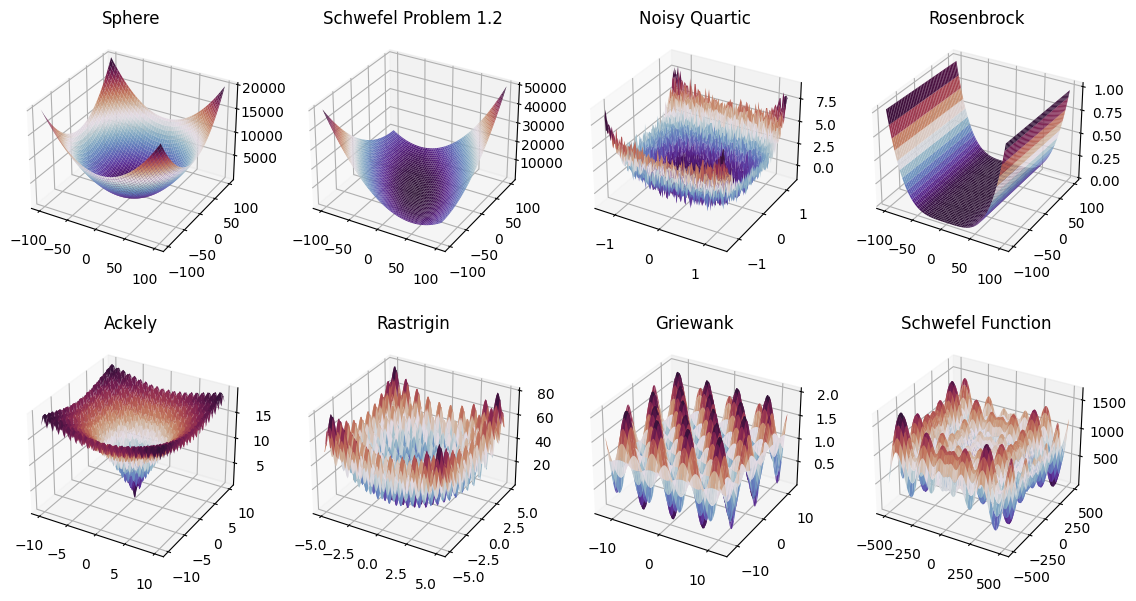

In [9]:
# 3D Function Visualisations

# Here we can experiment with the bounds to ensure each function has been correctly implemented. We can view the modality etc. of different functions using these plots
FunctionObjects = [SphereFunctionObject(2), SchwefelProblemObject(2), NoisyQuarticFunctionObject(2, noise_scale = 0.5), RosenbrockFunctionObject(2), 
                   AckleyFunctionObject(2, -10, 10), RastriginFunctionObject(2), GriewankFunctionObject(2, -12, 12), SchwefelFunctionObject(2)]
titles = ['Sphere', 'Schwefel Problem 1.2', 'Noisy Quartic', 'Rosenbrock', 'Ackely', 'Rastrigin', 'Griewank', 'Schwefel Function']

# Iterating through objects and plotting 3D surface plots
fig = plt.figure(figsize = (12,6))
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.2, hspace=0.3)

for i, (FunctionObject, title) in enumerate(zip(FunctionObjects, titles)):
    ax = fig.add_subplot(2, 4, i+1, projection = '3d')
    x = np.linspace(FunctionObject.getbounds()[0][0], FunctionObject.getbounds()[0][1], 100)
    y = np.linspace(FunctionObject.getbounds()[0][0], FunctionObject.getbounds()[0][1], 100)
    X, Y = np.meshgrid(x, y)
    Z = np.array([[FunctionObject.function(np.array([xi, yi])) for xi in x] for yi in y])
    ax.plot_surface(X, Y, Z, cmap = 'twilight_shifted')
    ax.set_title(title)

plt.tight_layout
plt.savefig('TestSuite.png')
plt.show()

### **Example of Running Algorithm**

In [16]:
# ---- Example Of Running Search Algorithm ----

# First select the function and dimensionality you want to optimise
f = AckleyFunctionObject(2) # e.g. this is 3D (x1, x2 in solution hence 2)

# Next Generate the bounds
bounds = f.getbounds()

# Next define the schema you want to operate in
schema = best1(0.6) # e.g. this is the best/1/bin schema with F = 0.6

# Next setup the search algorithm with the problem and parameters
DE = DifferentiaEvolution(f.function, f.getbounds(), 100, 100, 0.3, schema, 500) # See __init__ function signature for explanation of other input var's

# Finally we can run our algorithm with .run() method and store results in variables
SolutionQuality, MinimaCoords, ConvergenceSpeed, ExecutionTime, DiversityMetric, LowestCostHistory, AvgCostHistory = DE.run()
print('Identified Minima:', SolutionQuality, ' Minima Coordinates; ', MinimaCoords)

Identified Minima: 4.440892098500626e-16  Minima Coordinates;  [-2.23271585e-18 -1.88287888e-16]
